In [1]:
%matplotlib notebook
import pymunk
import pymunk.matplotlib_util
from pymunk.vec2d import Vec2d
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import animation

import math, functools, random, traceback

import numpy as np

def print_errors_to_stdout(fun):
    @functools.wraps(fun)
    def wrapper(*args,**kw):
        try:
            return fun(*args,**kw)
        except Exception:
            traceback.print_exc()
            raise
    return wrapper

In [ ]:
fig = plt.figure(figsize=(8, 5), tight_layout=True)
ax = plt.axes(xlim=(0, 2000), ylim=(0, 1000))
ax.set_aspect("equal")

space = pymunk.Space()
space.gravity = 0, 0
space.damping = 1

width, height = 2000, 1000

def make_grippers(x, y, start_distance, angle, length=200, velocity=50):
    """Makes a gripper"""
    # computing slope, slope of perpendicular
    slope = math.tan(angle)
    orth_slope = -1/slope if not np.isclose(0, slope) else -math.inf
    length, start_distance = length / 2, start_distance / 2
    
    # starting position offsets
    x_offset = start_distance/math.sqrt(orth_slope**2+1)
    y_offset = (orth_slope*start_distance)/math.sqrt(orth_slope**2+1)
    
    # squeeze velocity components, magnitude of velocity vector = velocity
    vel_x = velocity/math.sqrt(orth_slope**2+1)
    vel_y = velocity*orth_slope/math.sqrt(orth_slope**2+1)
    
    # Bottom Gripper
    bot = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
    bot.position = x-x_offset, y-y_offset
    # bot_seg = pymunk.Segment(bottom, a=(-l, -l*slope), b=(l, l*slope), radius=2)
    bot_seg = pymunk.Segment(bot, a=(-length, 0), b=(length, 0), radius=2)
    bot_seg.friction = 0
    bot.angle = angle
    bot_squeeze_velocity = Vec2d(vel_x, vel_y)
    
    # top gripper
    top = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
    top.position = x+x_offset, y+y_offset
    # top_seg = pymunk.Segment(top, a=(-l, -l*slope), b=(l, l*slope), radius=2)
    top_seg = pymunk.Segment(top, a=(-length, 0), b=(length, 0), radius=2)
    top_seg.friction = 0
    top.angle = angle
    top_squeeze_velocity = -Vec2d(vel_x, vel_y)
    
    return (top, top_seg, top_squeeze_velocity), (bot, bot_seg, bot_squeeze_velocity)

def make_pos_limiter(x_final, y_final, eps=2):
    def position_func(body, dt):
        if abs(body.position.x-x_final) < eps and abs(body.position.y-y_final) < eps:
            body.velocity = 0, 0

grippers = []
grippers.append(make_grippers(500, 500, 200, math.pi/4))
grippers.append(make_grippers(750, 500, 200, math.pi/2))

for top, bot in grippers:
    space.add(*top[:2])
    space.add(*bot[:2])

def make_box():
    body = pymunk.Body(1, 10000, body_type=pymunk.Body.DYNAMIC)
    body.position = 250, 500
    box = pymunk.Poly.create_box(body, size=(50, 50))
    box.friction = 0
    # box.mass = 10000
    body.angle = random.uniform(0, 2*math.pi)
    body.position_func = position_update
    
    return body, box

boxes = []

o = pymunk.matplotlib_util.DrawOptions(ax)

def constant_angular_velocity(body, gravity, damping, dt):
    pymunk.Body.update_velocity(body, gravity, damping, dt)
    body.angular_velocity = 0
    
def position_update(body, dt):
    if int(body.position.x) in [250, 500, 750] and d >= 5:
        body.velocity = body.velocity * 0
    if body.position.x >= 750:
        space.remove(body, *body.shapes)
    pymunk.Body.update_position(body, dt)
    
# def position_limiter(body, dt):
#     if int(body.position.y) in [400, 600]:
#         body.velocity = 0, 0
        
#     pymunk.Body.update_position(body, dt)

def init():
    space.debug_draw(o)
    return []

MOVE_PART_TIME = 200
SQUEEZE_PART_TIME = 150
UNSQUEEZE_PART_TIME = 150
TOTAL_TIME = MOVE_PART_TIME + SQUEEZE_PART_TIME + UNSQUEEZE_PART_TIME

d = 0

@print_errors_to_stdout
def animate(dt):
    global d

    dt = dt % 500
    d = dt
    if dt == 0:
        # create a new box; start moving all boxes to next one
        boxes.insert(0, make_box())
        space.add(*boxes[0])
        
        for body, box in boxes:
            body.velocity = 100, 0
    elif dt == 200:
        for body, box in boxes:
            body.velocity_func = pymunk.Body.update_velocity
        
        for top, bot in grippers:  
            top_body, top_seg, top_vel = top
            bot_body, bot_seg, bot_vel = bot
            
            top_body.position_func = pymunk.Body.update_position
            bot_body.position_func = pymunk.Body.update_position
        
            bot_body.velocity = bot_vel
            top_body.velocity = top_vel
    elif 200 < dt < 350:
        for top, bot in grippers:
            top_body, top_seg, top_vel = top
            bot_body, bot_seg, bot_vel = bot
            
            distance = top_body.position.get_distance(bot_body.position)
            if distance < 50:
                top_body.velocity = top_body.velocity * 0
                bot_body.velocity = bot_body.velocity * 0
    elif dt == 350:
        for body, box in boxes:
            body.velocity_func = constant_angular_velocity
        
        for top, bot in grippers:
            top_body, top_seg, top_vel = top
            bot_body, bot_seg, bot_vel = bot
            
            bot_body.velocity = -bot_vel
            top_body.velocity = -top_vel

            top_body.position_func = position_limiter
            bot_body.position_func = position_limiter
    elif dt > 350:
        pass
        
    for x in range(10):
        space.step(1/50/10)
    ax.clear()
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    space.debug_draw(o)
    
    ax.set_title(f'{round(boxes[0][0].angle, 3)} | {boxes[0][0].velocity} | {dt} | {boxes[0][0].position.x}')
    # return []

frames = 500
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=20, blit=False)
plt.show()
# HTML(anim.to_html5_video())

In [22]:
class Gripper:
    
    filter = pymunk.ShapeFilter(categories=0b01, mask=0b10)
    
    def __init__(self, x, y, angle, distance=200, length=200, velocity=50):
        # computing slope, slope of perpendicular
        self.slope = math.tan(angle)
        self.orth_slope = -1/self.slope if not np.isclose(0, self.slope) else -math.inf
        length, distance = length / 2, distance / 2
        
        # starting position offsets
        self.x_offset = distance/math.sqrt(self.orth_slope**2+1)
        self.y_offset = (self.orth_slope*distance)/math.sqrt(self.orth_slope**2+1)
        
        # squeeze velocity components, magnitude of velocity vector = velocity
        self.vel_x = velocity/math.sqrt(self.orth_slope**2+1)
        self.vel_y = velocity*self.orth_slope/math.sqrt(self.orth_slope**2+1)
        
        # bottom gripper
        self.bot_vel = Vec2d(self.vel_x, self.vel_y) # squeeze velocity vector
        self.bot_pos = Vec2d(x-self.x_offset, y-self.y_offset) # starting position vector
        self.bot_limiter = Gripper.make_pos_limiter(self.bot_pos)
        
        self.bot = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        self.bot.position = self.bot_pos
        self.bot_seg = pymunk.Segment(self.bot, a=(-length, 0), b=(length, 0), radius=2)
        self.bot_seg.friction = 0
        self.bot_seg.filter = Gripper.filter
        self.bot.angle = angle
        
        # top gripper
        self.top_vel = -Vec2d(self.vel_x, self.vel_y) # squeeze velocity vector
        self.top_pos = Vec2d(x+self.x_offset, y+self.y_offset) # starting position vector
        self.top_limiter = Gripper.make_pos_limiter(self.top_pos)
        
        self.top = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        self.top.position = self.top_pos
        self.top_seg = pymunk.Segment(self.top, a=(-length, 0), b=(length, 0), radius=2)
        self.top_seg.friction = 0
        self.top_seg.filter = Gripper.filter
        self.top.angle = angle
    
    @staticmethod
    def make_pos_limiter(pos, eps=1):
        def position_func(body, dt):
            if (body.position - pos).length < eps:
                body.velocity = 0, 0
            pymunk.Body.update_position(body, dt)
                
        return position_func
                
    def squeeze(self):
        self.bot.velocity = self.bot_vel
        self.top.velocity = self.top_vel
        
    def unsqueeze(self):
        self.bot.velocity = -self.bot_vel
        self.top.velocity = -self.top_vel
    
    def stop(self):
        self.bot.velocity = 0, 0
        self.top.velocity = 0, 0
        
    def limit_position(self):
        self.bot.position_func = self.bot_limiter
        self.top.position_func = self.top_limiter
        
    def reset_pos_func(self):
        self.bot.position_func = pymunk.Body.update_position
        self.top.position_func = pymunk.Body.update_position
        
    def reset_vel_func(self):
        self.bot.velocity_func = pymunk.Body.update_velocity
        self.top.velocity_func = pymunk.Body.update_velocity
        
    def distance(self):
        return self.bot.position.get_distance(self.top.position)

In [46]:
class Polygon:
    
    squeeze_filter = pymunk.ShapeFilter(categories=0b10, mask=pymunk.ShapeFilter.ALL_MASKS())
    move_filter = pymunk.ShapeFilter(categories=0b10, mask=pymunk.ShapeFilter.ALL_MASKS() ^ 0b01)
    
    gripper_pos = []
    del_pos = math.inf
    state = 0
    
    def __init__(self, x, y, points, angle=None):
        self.points = list(map(tuple, points))
        self.body = pymunk.Body(1, 10000, body_type=pymunk.Body.DYNAMIC)
        self.body.position = x, y
        
        self.poly = pymunk.Poly(self.body, self.points)
        self.poly.friction = 0
        
        if angle is None:
            self.body.angle = random.uniform(0, 2*math.pi)
        
    def reset_pos_func(self):
        self.body.position_func = pymunk.Body.update_position
        
    def reset_vel_func(self):
        self.body.velocity_func = pymunk.Body.update_velocity
        
    def move(self):
        self.body.velocity = 100, 0
        self.poly.filter = Polygon.move_filter
        self.body.velocity_func = Polygon.constant_angular_velocity
        self.body.position_func = Polygon.limit_pos
        
    def squeeze(self):
        self.poly.filter = Polygon.squeeze_filter
        self.reset_vel_func()
        
    @staticmethod
    def limit_pos(body, dt):
        if int(body.position.x) in Polygon.gripper_pos and Polygon.state >= 5:
            body.velocity = body.velocity * 0
        if body.position.x >= Polygon.del_pos:
            space.remove(body, *body.shapes)
        
        pymunk.Body.update_position(body, dt)
        
    @staticmethod
    def constant_angular_velocity(body, gravity, damping, dt):
        pymunk.Body.update_velocity(body, gravity, damping, dt)
        body.angular_velocity = 0

In [73]:
class Display:
    
    MOVE_PART_TIME = 200
    SQUEEZE_PART_TIME = 150
    UNSQUEEZE_PART_TIME = 150
    TOTAL_TIME = MOVE_PART_TIME + SQUEEZE_PART_TIME + UNSQUEEZE_PART_TIME
    
    def __init__(self, points, angles):
        self.angles = angles
        self.points = points
        
        self.fig = plt.figure(figsize=(8, 5), tight_layout=True)
        
        self.gripper_pos = [i * 250 for i in range(1, len(angles)+1)]
        self.start_pos = 0
        self.del_pos = (len(angles) + 1) * 250
        
        self.xlim = (self.start_pos, self.del_pos)
        self.ylim = (-200, 200)
        
        self.ax = plt.axes(xlim=self.xlim, ylim=self.ylim)
        self.ax.set_aspect('equal')
        
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 1
        
        self.init_grippers()    
        self.polygons = []
    
        self.do = pymunk.matplotlib_util.DrawOptions(self.ax)
        
        Polygon.gripper_pos = self.gripper_pos
        Polygon.del_pos = self.del_pos
        
    def init_grippers(self):
        self.grippers = []
        
        for angle, xpos in zip(self.angles, self.gripper_pos):
            g = Gripper(xpos, 0, angle)
            
            self.grippers.append(g)
            self.space.add(g.top, g.top_seg)
            self.space.add(g.bot, g.bot_seg)
    
    def add_polygon(self):
        p = Polygon(self.start_pos, 0, self.points)
        self.polygons.insert(0, p)
        self.space.add(p.body, p.poly)
        
    def make_animation(self):
        animate = self.make_animate_func()
        init = lambda: self.space.debug_draw(self.do)
        self.anim = animation.FuncAnimation(self.fig, animate, init_func=init, 
                                            frames=Display.TOTAL_TIME, interval=2, blit=False)        
    
    def make_animate_func(self):     
        def animate(dt):
            dt = dt % 500
            Polygon.state = dt
            if dt == 0:
                # create a new box; start moving all boxes to next one
                self.add_polygon()

                for p in self.polygons:
                    p.move()
            elif 0 < dt < 200:
                pass
            elif dt == 200:
                for p in self.polygons:
                    p.squeeze()

                for g in self.grippers:  
                    g.reset_pos_func()
                    g.squeeze()          
            elif 200 < dt < 350:
                for g in self.grippers: 
                    distance = g.distance()
                    if distance < 50:
                        g.stop()
            elif dt == 350:
                for p in self.polygons:
                    p.body.velocity_func = Polygon.constant_angular_velocity

                for g in self.grippers:
                    g.unsqueeze()
                    g.limit_position()
            elif dt > 350:
                pass

            for x in range(10):
                self.space.step(1/50/10)
            self.ax.clear()
            self.ax.set_xlim(*self.xlim)
            self.ax.set_ylim(*self.ylim)
            self.space.debug_draw(self.do)

            self.ax.set_title(f'{dt}')
            
        return animate

<IPython.core.display.Javascript object>


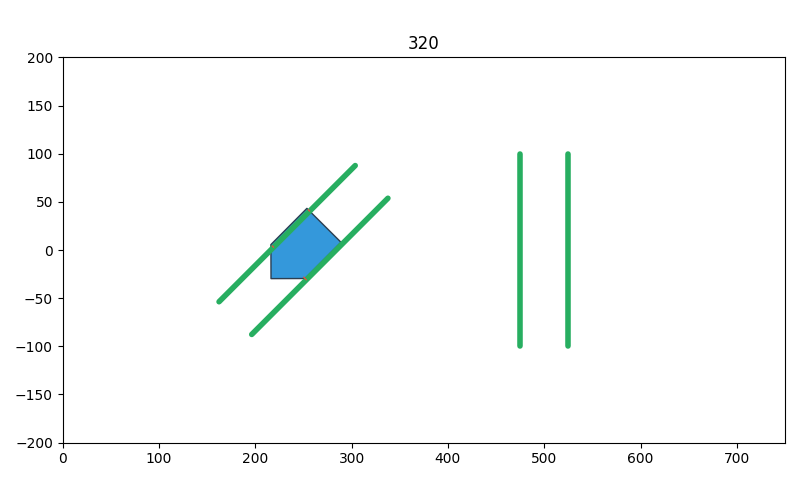

In [74]:
points = list(map(tuple, np.array([(-25, -33), (25, -33), (25, 20), (0, 45), (-25, 20)])))

d = Display(points, [math.pi/4, math.pi/2])
d.make_animation()

<IPython.core.display.Javascript object>


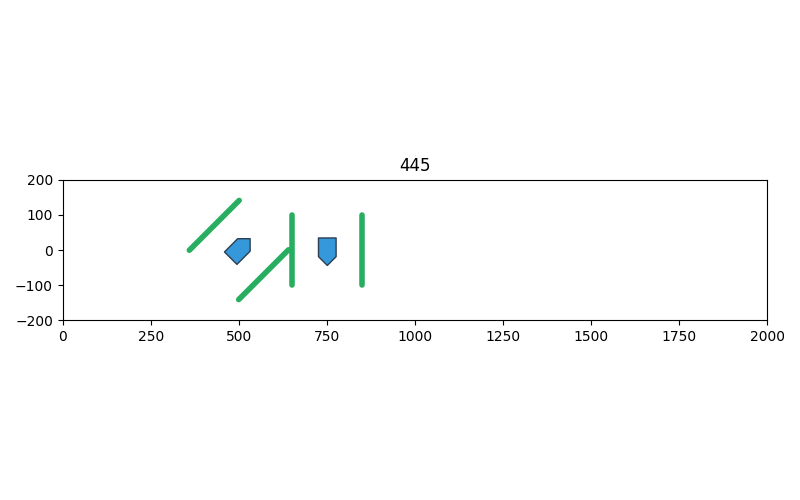

In [54]:
fig = plt.figure(figsize=(8, 5), tight_layout=True)
xlim, ylim = (0, 2000), (-200, 200)
ax = plt.axes(xlim=xlim, ylim=ylim)
ax.set_aspect("equal")

points = list(map(tuple, np.array([(-25, -33), (25, -33), (25, 20), (0, 45), (-25, 20)])))

space = pymunk.Space()
space.gravity = 0, 0
space.damping = 1

grippers = []
grippers.append(Gripper(500, 0, math.pi/4))
grippers.append(Gripper(750, 0, math.pi/2))

for g in grippers:
    space.add(g.top, g.top_seg)
    space.add(g.bot, g.bot_seg)
    
boxes = []

o = pymunk.matplotlib_util.DrawOptions(ax)
    
Polygon.gripper_pos = [250, 500, 750]
Polygon.del_pos = 1000
    
def init():
    space.debug_draw(o)

MOVE_PART_TIME = 200
SQUEEZE_PART_TIME = 150
UNSQUEEZE_PART_TIME = 150
TOTAL_TIME = MOVE_PART_TIME + SQUEEZE_PART_TIME + UNSQUEEZE_PART_TIME

@print_errors_to_stdout
def animate(dt):
    dt = dt % 500
    Polygon.state = dt
    if dt == 0:
        # create a new box; start moving all boxes to next one
        boxes.insert(0, Polygon(250, 0, points))
        space.add(boxes[0].body, boxes[0].poly)
        
        for p in boxes:
            p.move()
    elif 0 < dt < 200:
        pass
    elif dt == 200:
        for p in boxes:
            p.squeeze()
        
        for g in grippers:  
            g.reset_pos_func()
            g.squeeze()          
    elif 200 < dt < 350:
        for g in grippers: 
            distance = g.distance()
            if distance < 50:
                g.stop()
    elif dt == 350:
        for p in boxes:
            p.body.velocity_func = Polygon.constant_angular_velocity
        
        for g in grippers:
            g.unsqueeze()
            g.limit_position()
    elif dt > 350:
        pass
          
    for x in range(10):
        space.step(1/50/10)
    ax.clear()
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    space.debug_draw(o)
    
    ax.set_title(f'{dt}')
    # return []

frames = 500
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=2, blit=False)